# Richmond Metro Area Housing Price Forecasting Using Time Series Analysis

#### By Gary Schwaeber

![RVA](images/Downtown-Richmond-VA.jpeg)

## Business Problem

A house flipping company in Richmond has hired me to analyze house price appreciation in various zipcodes. It takes them approximtely 1 year to buy, renovate and begin selling a home. Due to their limited resources, they want to target areas where house prices will have the greatest price appreciation in one year.  

### Process

To help the company, I will do time series analyses on housing prices in various zipcodes, make forecasts of prices a year down the line, and calculate the annualized % appreciation. I will do forecasts using both tuned SARIMA models and Facbook Prophet models. Then I will take the weighted average results from each model forecast. The zipcode with the highest % appreciation will be recommended to the company as the area for them to target their investments.

In [1]:
from random import gauss as gs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import itertools
from varname import nameof


#statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima   
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
pd.plotting.register_matplotlib_converters()
from statsmodels.tools.eval_measures import rmse


import os, sys
import warnings
warnings.simplefilter('ignore')

%matplotlib inline

## Data

The original data is gathered from [Zillow](https://www.zillow.com/research/data/). The dataframe contains the ZHVI for single family homes from every zipcode in the US from 1/31/1996 to 2/28/2021 on a monthly interval. The Zillow Home Value Index (ZHVI) is a smoothed, seasonally adjusted measure of the typical home value and market changes across a given region and housing type. It reflects the typical value for homes in the 35th to 65th percentile range. 



In [2]:
df = pd.read_csv('data/Zip_zhvi_uc_sfr_tier_0.33_0.67_sm_sa_mon.csv')

In [3]:
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1/31/96,...,5/31/20,6/30/20,7/31/20,8/31/20,9/30/20,10/31/20,11/30/20,12/31/20,1/31/21,2/28/21
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,...,1251067,1243911,1242393,1243116,1249957,1253918,1256918,1260189,1255048,1247237
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,360618.0,...,964280,964191,965875,968256,973015,978022,981918,985428,987405,991571
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,...,1533387,1534731,1533831,1534093,1534862,1541697,1549960,1557635,1558745,1558968
3,91982,3,77494,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,200194.0,...,337319,338148,338871,340299,341862,344329,347347,351632,355788,360651
4,84616,4,60614,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,547552.0,...,1204098,1205314,1208072,1211021,1216680,1222663,1228051,1233108,1236396,1243489


The below function filters for row with for the relevant zipcode, takes the row and reformats it so that is suitable for time series analysis. I am adding an exogenous variable, the financial crisi flag, to account for the price trend changing during the Great Recession. 

In [4]:
def format_df(df, zip_code):
    df = df[df['RegionName'] == zip_code]
    df = df.iloc[:,9:].transpose()
    df.index = pd.to_datetime(df.index, infer_datetime_format=True)
    df = df.rename(columns={df.columns[0]: 'Zillow Home Value Index (ZHVI)'})
    df.dropna(inplace = True)
    df['financial_crisis_flag'] = 0
    df.loc['2007-08-30': '2012-01-31', 'financial_crisis_flag'] = 1

    return df

The zipcodes that were requested are as follows:  
23060 contains of the towns of Glen Allen and Innsbrook, suburbs of Richmond  
23226 contains the West End of the city  
23221 contains Carrytown, the Museum District, and Windsor Farms, thriving cultural areas of the city and adjacent suburbs.  
23220 contains the Fan District a central urban neighborhood where VCU is located, and surrounding areas.  
23227 contains the neighborhood of Bellevue, a picturesque area just outside the city and the town of Chamberlayne.  
![image](images/richmond_zipcodes.png)



In [5]:
z23060 = format_df(df, 23060)
z23226 = format_df(df, 23226)
z23221 = format_df(df, 23221)
z23220 = format_df(df, 23220)
z23227 = format_df(df, 23227)

In [6]:
z23060.head()

,Zillow Home Value Index (ZHVI),financial_crisis_flag
1996-01-31,134361.0,0
1996-02-29,134166.0,0
1996-03-31,134249.0,0
1996-04-30,134266.0,0
1996-05-31,134632.0,0


We can see the changes in price over time for the five zipcodes. Of note,the period around 2007 to 2012 the trend in each zipcode changes and becomes negative. This was during the Great Recession when the US housing bubble burst. Adding the financial crisis flag to the model as an exogenous variable will help the models account for the difference in trend during this period. 

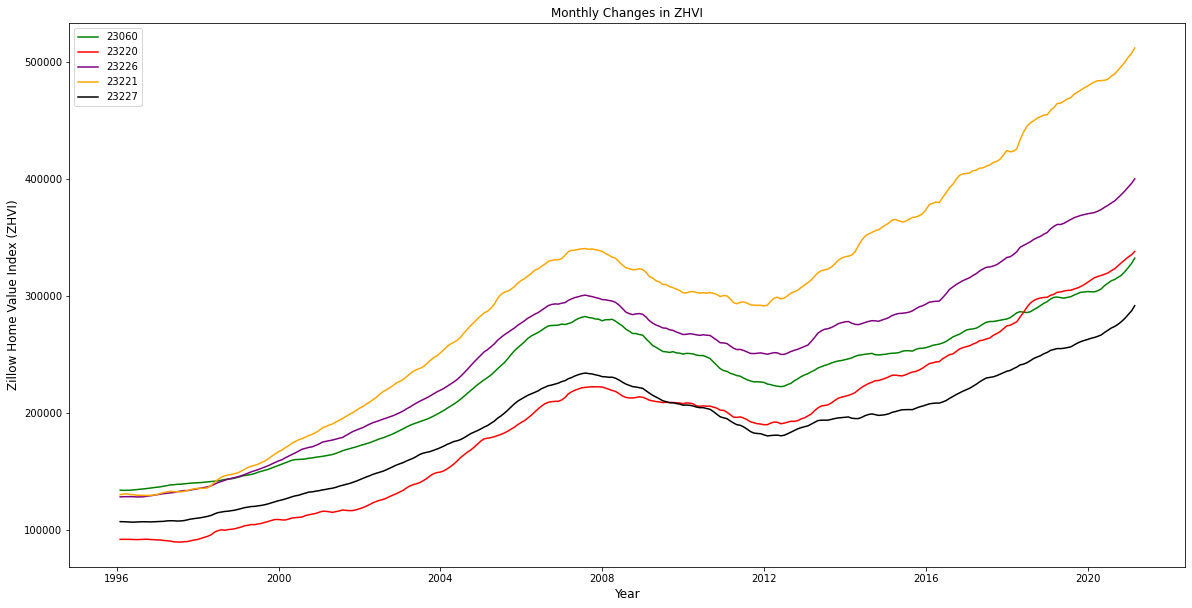

In [7]:
fig, ax = plt.subplots(figsize = (20,10))


ax.plot(z23060['Zillow Home Value Index (ZHVI)'], color = 'g', label = '23060')
ax.plot(z23220['Zillow Home Value Index (ZHVI)'], color = 'r', label = '23220')
ax.plot(z23226['Zillow Home Value Index (ZHVI)'], color = 'purple', label = '23226')
ax.plot(z23221['Zillow Home Value Index (ZHVI)'], color = 'orange', label = '23221')
ax.plot(z23227['Zillow Home Value Index (ZHVI)'], color = 'black', label = '23227')
ax.set_ylabel('Zillow Home Value Index (ZHVI)', fontsize = 12)
ax.set_xlabel('Year', fontsize = 12)
plt.legend()

ax.set_title(f"Monthly Changes in ZHVI");

In [8]:
### the below splits the data into training and test set. 90% is used for training. it iterates through different pdqs find the AIC and returns the results in a dataframe
def find_sarimax_parameters(df):
    cutoff = round(df.shape[0]*0.9)
    train = df['Zillow Home Value Index (ZHVI)'][:cutoff].dropna()
    exog  = df.dropna()['financial_crisis_flag'][:cutoff]
    
    p = q = range(0,4)
    d = range(0,3)
    pdq = list(itertools.product(p, d, q))
    
    seasonal_pdq = list(itertools.product([0,1], [0], [0,1], [12]))
    
    results_dict = {}
    
    for o in pdq:
        for so in seasonal_pdq:
            try:
                model = SARIMAX(endog = train, exog = exog, order=o, seasonal_order=so, freq = 'M').fit()
                order = 'order='+str(o)+'seasonal'+str(so)
                results_dict[order] = model.aic
            except: 
                continue

    
    rdf = pd.DataFrame(results_dict.items(), columns = ['Paramters', 'AIC'])
    
    return rdf.sort_values('AIC').head(20)

In [9]:
#code is the same as find_sarimax_parameters just with no exogenous variable, this was used to see if I should include the financial crisi flag or not. 
def find_sarimax_parameters_no_exog(df):
    cutoff = round(df.shape[0]*0.9)
    train = df['Zillow Home Value Index (ZHVI)'][:cutoff].dropna()
    exog  = df.dropna()['financial_crisis_flag'][:cutoff]
    
    p = q = range(0,4)
    d = range(0,3)
    pdq = list(itertools.product(p, d, q))
    
    seasonal_pdq = list(itertools.product([0,1], [0], [0,1], [12]))
    
    results_dict = {}
    
    for o in pdq:
        for so in seasonal_pdq:
            try:
                model = SARIMAX(endog = train, order=o, seasonal_order=so, freq = 'M').fit()
                order = 'order='+str(o)+'seasonal'+str(so)
                results_dict[order] = model.aic
            except: 
                continue
                            
    temp = min(results_dict.values())
    res = [key for key in results_dict if results_dict[key] == temp]
    print(res, temp)
    return results_dict

In [10]:
###code courtesy of Flatiron School curriculum
def test_stationarity(timeseries, window):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:], color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value', '#Lags Used',
                                             'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print (dfoutput)

In [11]:
#code for analyzing how doing 1 year stepwise forecasting on the models performs. Model is retrained after every forecast. Only the forecast 12 months in advances is kept for analysis
def year_stepwise_test_results(df, order, seasonal_order):

    cutoff = round(df.shape[0]*0.9)
    train = df['Zillow Home Value Index (ZHVI)'][:cutoff].dropna()
    exog  = df.dropna()['financial_crisis_flag'][:cutoff]
    test = df['Zillow Home Value Index (ZHVI)'][cutoff:]
    i = 0
    history = [x for x in train]
    predictions = []

    for t in range(len(test)):

        model = SARIMAX(endog = history, exog = exog, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit()
        output = model_fit.forecast(steps =12, exog = np.zeros(12))
        yhat = output[-1]

        predictions.append(yhat)
        obs = test[t]
        history.append(obs)

        exog = exog.append(df.iloc[cutoff+i:cutoff+1+i,1])
        i+=1


    # evaluate forecasts
    predictions = pd.Series(data=predictions[:20], index = test.index[10:])
    RMSE = rmse(test[10:], predictions)

    #plot train, test and forecast values
 
    fig, ax = plt.subplots(figsize = (12,8))
    ax.plot(train, label='train')
    ax.plot(test, label='test')
    #     ax.plot(y_hat_train, label='train_pred')
    ax.plot(predictions, label='12 month test forecasts')
    ax.set_ylabel('Zillow Home Value Index (ZHVI)', fontsize = 12)
    ax.set_xlabel('Year', fontsize = 12)
    ax.set_title('12 Month Stepwise Forecasts')
    plt.legend();
    plt.show()
    print(f'Test RMSE: {RMSE}')

In [12]:
### code for evaluating model. Different no stepwise forecasts are made, full prediction on train and test set
def model(df, order, seasonal_order):
    cutoff = round(df.shape[0]*0.9)
    train = df['Zillow Home Value Index (ZHVI)'][:cutoff].dropna()
    exog  = df.dropna()['financial_crisis_flag'][:cutoff]
    test = df['Zillow Home Value Index (ZHVI)'][cutoff:]

    model = SARIMAX(endog = train, exog = exog, order=order, seasonal_order=seasonal_order, freq = 'M').fit()
    y_hat_train = model.predict(start = train.index[2], typ='levels')
    y_hat_test = model.predict(start=test.index[0], end=test.index[-1],typ='levels', exog = np.zeros(len(test)))
    print(model.summary())

    print(f'Test RMSE: {rmse(test, y_hat_test)}')

    fig, ax = plt.subplots(figsize = (12,8))
    ax.plot(train, label='train')
    ax.plot(test, label='test')
    ax.plot(y_hat_train, label='train prediction')
    ax.plot(y_hat_test, label='test prediction')
    ax.set_ylabel('Zillow Home Value Index (ZHVI)', fontsize = 12)
    ax.set_xlabel('Year', fontsize = 12)
    plt.legend();
    plt.show()
    


In [13]:
#analysis for doing one period stepwise forecasts. In sample forecast is made one month ahead, model is retrained after every forecast
def one_period_stepwise_test_results(df, order, seasonal_order):

    cutoff = round(df.shape[0]*0.9)
    train = df['Zillow Home Value Index (ZHVI)'][:cutoff].dropna()
    exog  = df.dropna()['financial_crisis_flag'][:cutoff]
    test = df['Zillow Home Value Index (ZHVI)'][cutoff:]
    i = 0
    history = [x for x in train]
    predictions = []

    for t in range(len(test)):
        model = SARIMAX(endog = history, exog = exog, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit()
        output = model_fit.forecast(steps =1, exog = np.zeros(1))
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)

        exog = exog.append(z23060.iloc[cutoff+i:cutoff+1+i,1])
        i+=1


    # evaluate forecasts
    predictions = pd.Series(data=predictions, index = test.index)
    RMSE = rmse(test, predictions)
    print(f'Test RMSE: {RMSE}')

    fig, ax = plt.subplots(figsize = (12,8))

    ax.plot(test, label='test')
    #     ax.plot(y_hat_train, label='train_pred')
    ax.plot(predictions, label='one month test prediction')
    ax.set_ylabel('Zillow Home Value Index (ZHVI)', fontsize = 12)
    ax.set_xlabel('Year', fontsize = 12)
    ax.set_title('1 Month Stepwise Forecasts')
    plt.legend();
    plt.show()


## Exploratory Data Analysis and Modeling

### Modelling Process

#### Zipcode 23060

We can see below that the data is not stationary by looking at the trends in the chart as well as the Dickey-Fuller Test Results. At alpha of .05 we fail to reject the null hypothesis that the data is non-stationary.

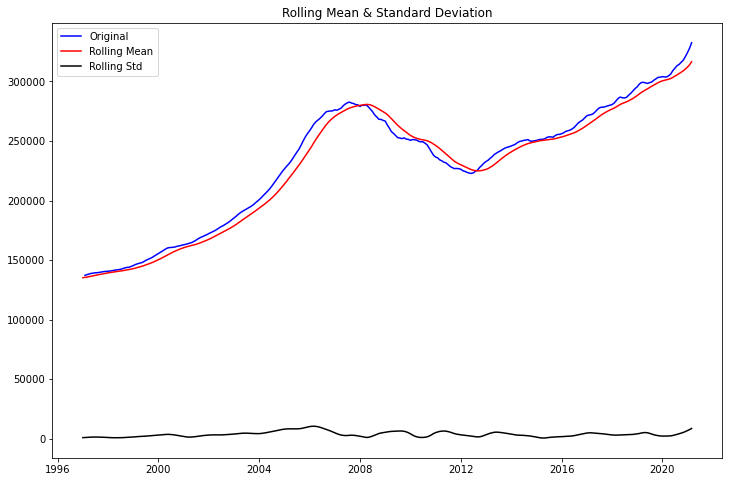

Results of Dickey-Fuller Test:
Test Statistic                  -0.501967
p-value                          0.891632
#Lags Used                      16.000000
Number of Observations Used    285.000000
Critical Value (1%)             -3.453505
Critical Value (5%)             -2.871735
Critical Value (10%)            -2.572202
dtype: float64


In [14]:
test_stationarity(z23060['Zillow Home Value Index (ZHVI)'], 12)

After differencing the data, we can see that it is still non-stationary. With a p-value of .51 on the Dickey-Fuller Test, we again fail to reject the null hypothesis that the differenced data is non-stationary.

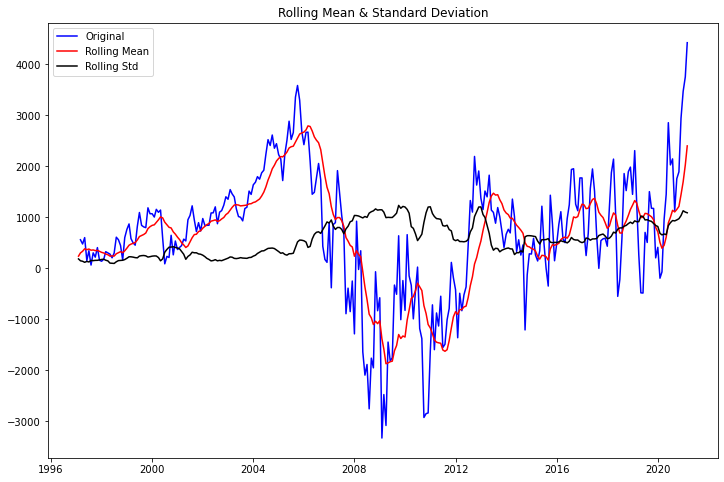

Results of Dickey-Fuller Test:
Test Statistic                  -1.543318
p-value                          0.511984
#Lags Used                      15.000000
Number of Observations Used    285.000000
Critical Value (1%)             -3.453505
Critical Value (5%)             -2.871735
Critical Value (10%)            -2.572202
dtype: float64


In [15]:
test_stationarity(z23060['Zillow Home Value Index (ZHVI)'].diff().dropna(), 12)

Finally after second differencing, the data is stationary and passes the Dickey-Fuller test with a p-value of 0.000005. This justifies putting 2 as the difference term in the SARIMA model. We get the same stationarity determination for every zipcode.

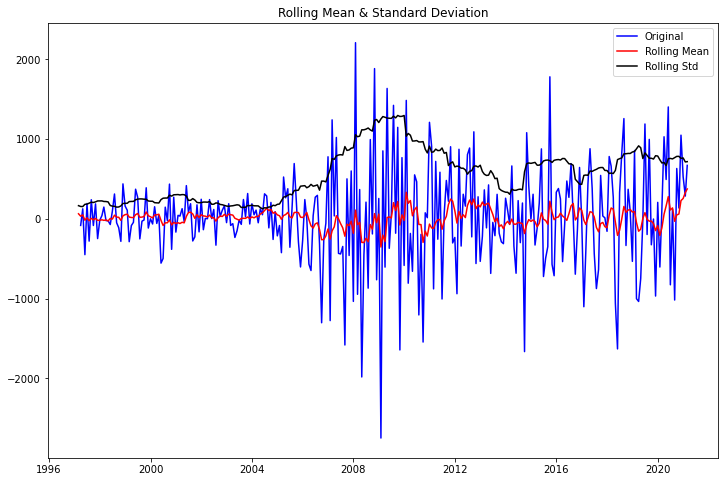

Results of Dickey-Fuller Test:
Test Statistic                  -5.332752
p-value                          0.000005
#Lags Used                      14.000000
Number of Observations Used    285.000000
Critical Value (1%)             -3.453505
Critical Value (5%)             -2.871735
Critical Value (10%)            -2.572202
dtype: float64


In [16]:
test_stationarity(z23060['Zillow Home Value Index (ZHVI)'].diff().diff().dropna(), 12)

Looking at the below Partial Autocorrelation chart, there appears to be significant partial autocorrelations up to 3 lags and then a seasona component at 12 lags. When later performing a grid search iteration of SARIMA paramters, I will search up 3 for the AR term and include a 12 month seasonal component as well. Similar finding persist for each subsequent zipcode. 

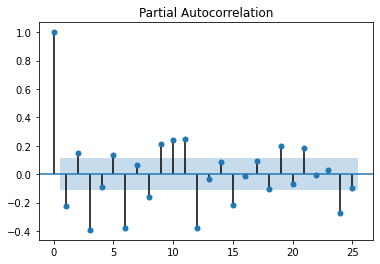

In [17]:
plot_pacf(z23060['Zillow Home Value Index (ZHVI)'].diff().diff().dropna());

Looking at the below Autocorrelation chart, there appears to be significant autocorrelations up to 3 lags and then a seasona component at 12 lags. When later performing a grid search iteration of SARIMA paramters, I will search up to 3 for the MA terms and include a 12 month seasonal component as well. Similar finding persist for each subsequent zipcode. 

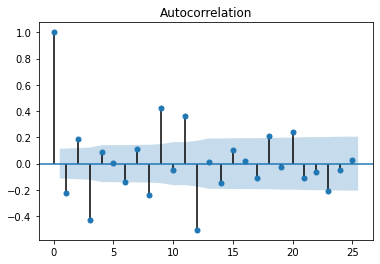

In [18]:
plot_acf(z23060['Zillow Home Value Index (ZHVI)'].diff().diff().dropna());

I iterate through different variation of parameters in the gridserach model and evaluate based on AIC. In a general sense, I will choose the lower AIC score, however since lower AIC doesn't necessarily gurantee the best model, I will also look at Test RMSE scores to determine the final paramters for the model. For zipcode 23060, order (0,2,3) and seasonal order (0,0,1,12) were determined to be the optimal paramters. 

In [19]:
find_sarimax_parameters(z23060)

,Paramters,AIC
45,"order=(0, 2, 3)seasonal(0, 0, 1, 12)",4208.553792
46,"order=(0, 2, 3)seasonal(1, 0, 0, 12)",4208.692409
177,"order=(3, 2, 0)seasonal(0, 0, 1, 12)",4209.413422
178,"order=(3, 2, 0)seasonal(1, 0, 0, 12)",4209.607118
47,"order=(0, 2, 3)seasonal(1, 0, 1, 12)",4210.528667
93,"order=(1, 2, 3)seasonal(0, 0, 1, 12)",4210.767660
182,"order=(3, 2, 1)seasonal(1, 0, 0, 12)",4210.814958
94,"order=(1, 2, 3)seasonal(1, 0, 0, 12)",4210.942598
181,"order=(3, 2, 1)seasonal(0, 0, 1, 12)",4211.333270
179,"order=(3, 2, 0)seasonal(1, 0, 1, 12)",4211.379163


                                      SARIMAX Results                                       
Dep. Variable:       Zillow Home Value Index (ZHVI)   No. Observations:                  272
Model:             SARIMAX(0, 2, 3)x(0, 0, [1], 12)   Log Likelihood               -2098.277
Date:                              Thu, 22 Apr 2021   AIC                           4208.554
Time:                                      19:06:53   BIC                           4230.144
Sample:                                  01-31-1996   HQIC                          4217.224
                                       - 08-31-2018                                         
Covariance Type:                                opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
financial_crisis_flag  -824.5000    288.104     -2.862      0.004   -1389.17

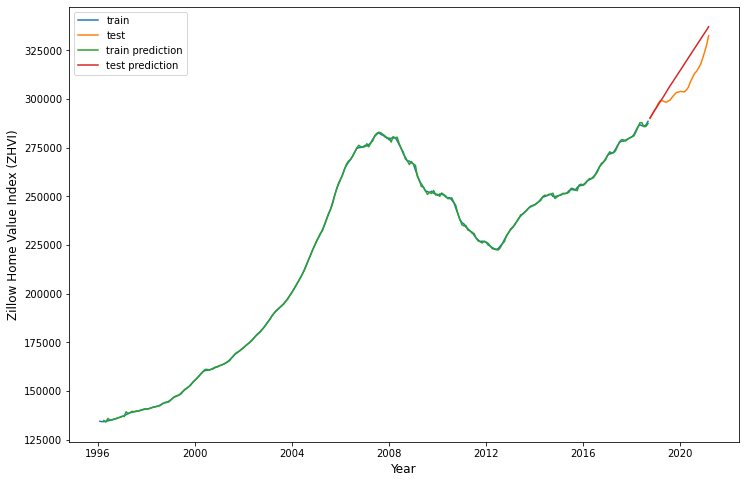

In [20]:
model(z23060, (0, 2, 3), (0, 0, 1, 12))

I perform one period stepwise forecasts, and evaluate against the actual test data to get a sense of how accurate the model is at predicting one month ahead. 

Test RMSE: 688.7642976907831


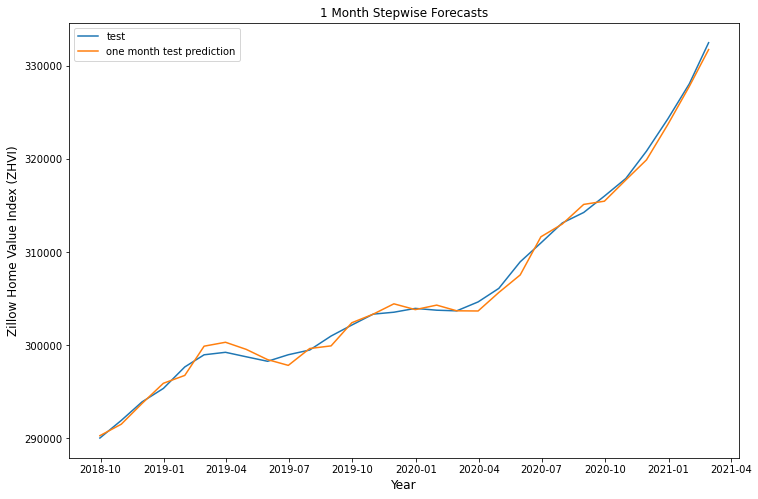

In [21]:
one_period_stepwise_test_results(z23060, (0, 2, 3), (0, 0, 1, 12))

By doing stepwise year ahead forecasts and evaluating against the actual test data, I can get a sense of how accurate the model will be for forecasting 12 months out. The RMSE gained from this process was also used to help me evalutate which pdq parameters were best for each zipcode. 

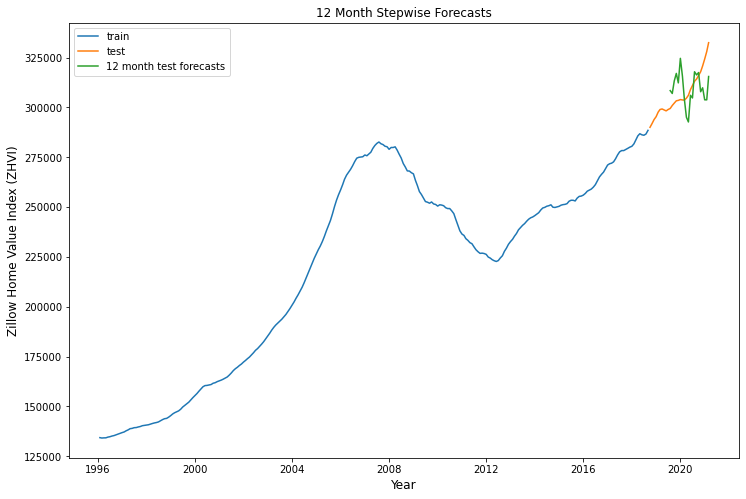

Test RMSE: 12125.4355990837


In [22]:
year_stepwise_test_results(z23060, (0, 2, 3), (0, 0, 1, 12))

---
#### Zipcode 23220

Zipcode 23220 saw similar results in paramter tuning as zipcode 23060. Best paramters for this zipcode were order = (0,2,3) and seasonal order = (0,0,1,12). The year stepwise testing did produce more accurate results than 23060, this may indicate more stable pricing trends in this zipcode and potentially more accurate out of sample forecasting.

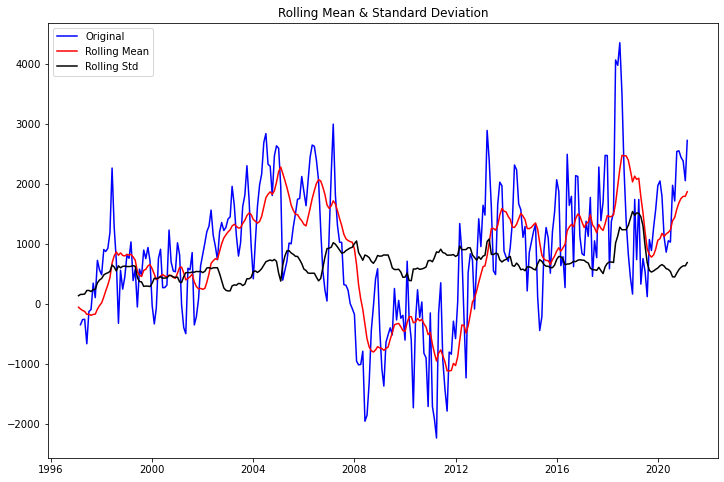

Results of Dickey-Fuller Test:
Test Statistic                  -1.952542
p-value                          0.307761
#Lags Used                      15.000000
Number of Observations Used    285.000000
Critical Value (1%)             -3.453505
Critical Value (5%)             -2.871735
Critical Value (10%)            -2.572202
dtype: float64


In [23]:
test_stationarity(z23220['Zillow Home Value Index (ZHVI)'].diff().dropna(), 12)

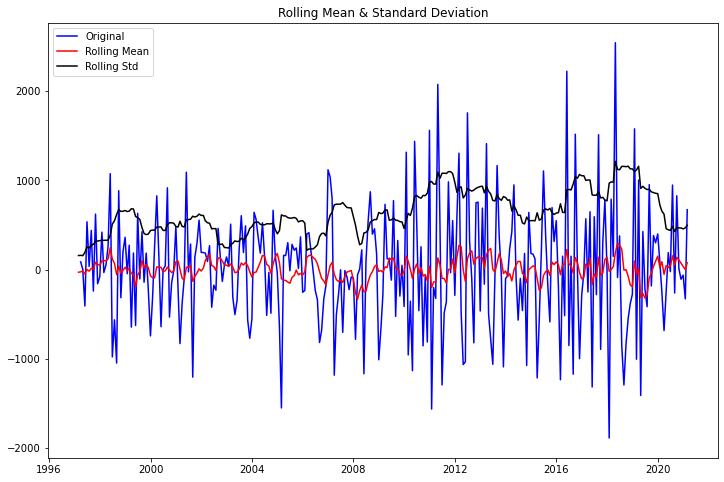

Results of Dickey-Fuller Test:
Test Statistic                -6.233220e+00
p-value                        4.895787e-08
#Lags Used                     1.400000e+01
Number of Observations Used    2.850000e+02
Critical Value (1%)           -3.453505e+00
Critical Value (5%)           -2.871735e+00
Critical Value (10%)          -2.572202e+00
dtype: float64


In [24]:
test_stationarity(z23220['Zillow Home Value Index (ZHVI)'].diff().diff().dropna(), 12)

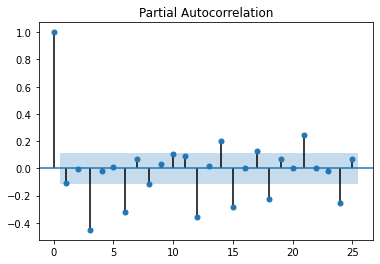

In [25]:
plot_pacf(z23220['Zillow Home Value Index (ZHVI)'].diff().diff().dropna());

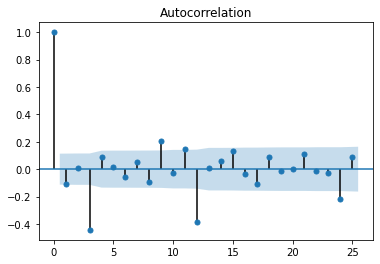

In [26]:
plot_acf(z23220['Zillow Home Value Index (ZHVI)'].diff().diff().dropna());

In [27]:
find_sarimax_parameters(z23220)

,Paramters,AIC
45,"order=(0, 2, 3)seasonal(0, 0, 1, 12)",4258.800663
47,"order=(0, 2, 3)seasonal(1, 0, 1, 12)",4259.804189
178,"order=(3, 2, 0)seasonal(1, 0, 1, 12)",4260.291420
176,"order=(3, 2, 0)seasonal(0, 0, 1, 12)",4260.800791
46,"order=(0, 2, 3)seasonal(1, 0, 0, 12)",4261.054014
94,"order=(1, 2, 3)seasonal(1, 0, 0, 12)",4261.317242
182,"order=(3, 2, 1)seasonal(1, 0, 1, 12)",4261.324913
177,"order=(3, 2, 0)seasonal(1, 0, 0, 12)",4261.591696
181,"order=(3, 2, 1)seasonal(1, 0, 0, 12)",4261.778533
95,"order=(1, 2, 3)seasonal(1, 0, 1, 12)",4262.501931


                                      SARIMAX Results                                       
Dep. Variable:       Zillow Home Value Index (ZHVI)   No. Observations:                  272
Model:             SARIMAX(0, 2, 3)x(0, 0, [1], 12)   Log Likelihood               -2123.400
Date:                              Thu, 22 Apr 2021   AIC                           4258.801
Time:                                      19:08:34   BIC                           4280.391
Sample:                                  01-31-1996   HQIC                          4267.470
                                       - 08-31-2018                                         
Covariance Type:                                opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
financial_crisis_flag  -426.8206    319.269     -1.337      0.181   -1052.57

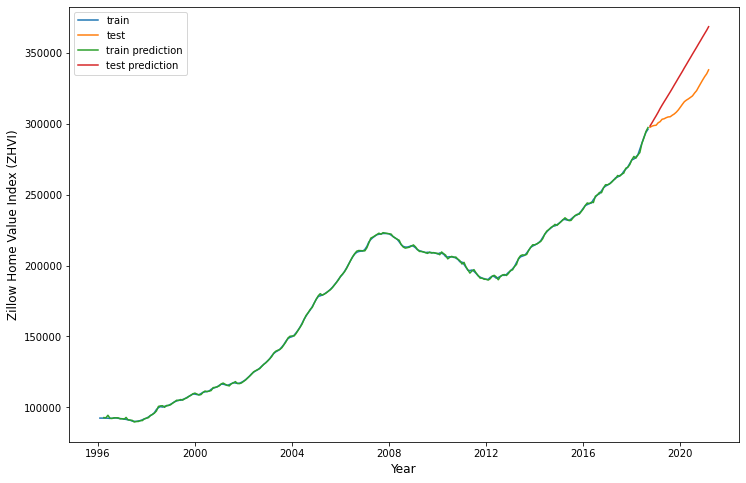

In [28]:
model(z23220, (0, 2, 3), (0, 0, 1, 12))

Test RMSE: 598.3865053577218


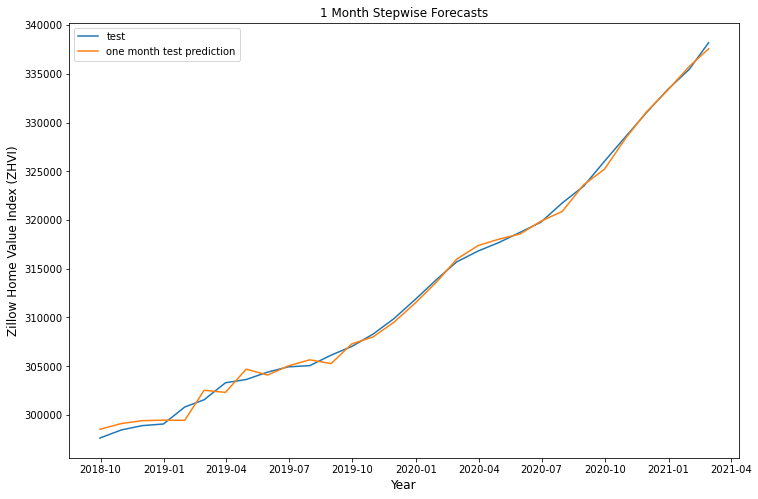

In [29]:
one_period_stepwise_test_results(z23220, (0, 2, 3), (0, 0, 1, 12))

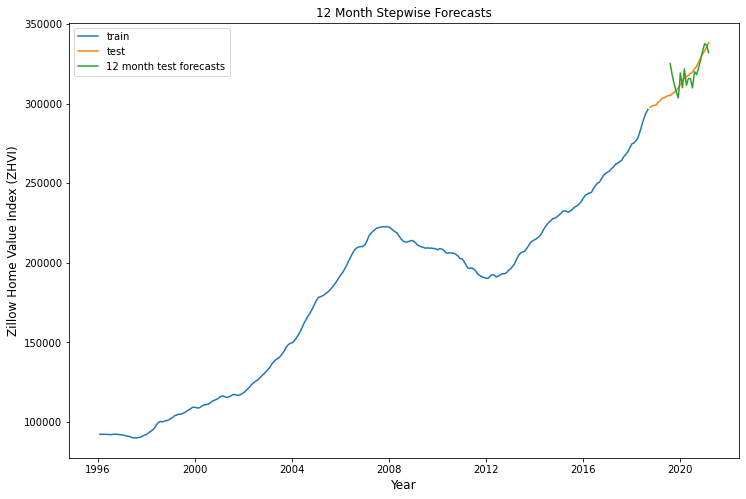

Test RMSE: 6910.820586873269


In [30]:
year_stepwise_test_results(z23220, (0, 2, 3), (0, 0, 1, 12))

---
#### Zipcode 23226

Zipcode 23226 saw similar results in paramter tuning as prior zipcodes. Best paramters for this zipcode were order = (0,2,3) and seasonal order = (0,0,1,12). 12 month stepwise forecast results were slightly worse than 23220 but still more accurate than 23060.

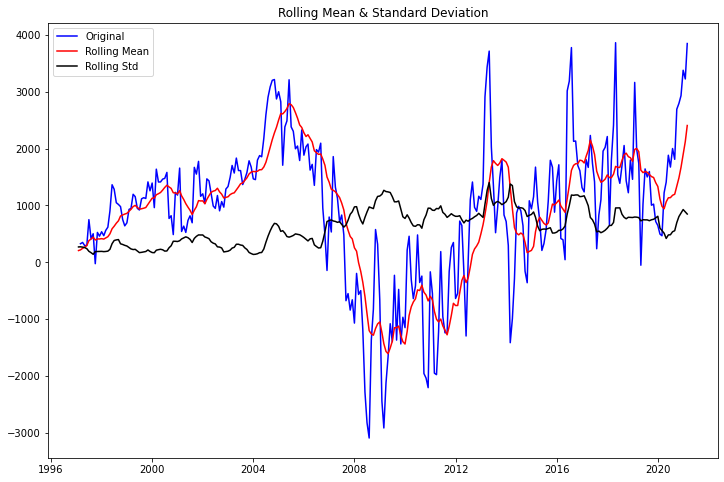

Results of Dickey-Fuller Test:
Test Statistic                  -1.709983
p-value                          0.425976
#Lags Used                      16.000000
Number of Observations Used    284.000000
Critical Value (1%)             -3.453587
Critical Value (5%)             -2.871771
Critical Value (10%)            -2.572222
dtype: float64


In [31]:
test_stationarity(z23226['Zillow Home Value Index (ZHVI)'].diff().dropna(), 12)

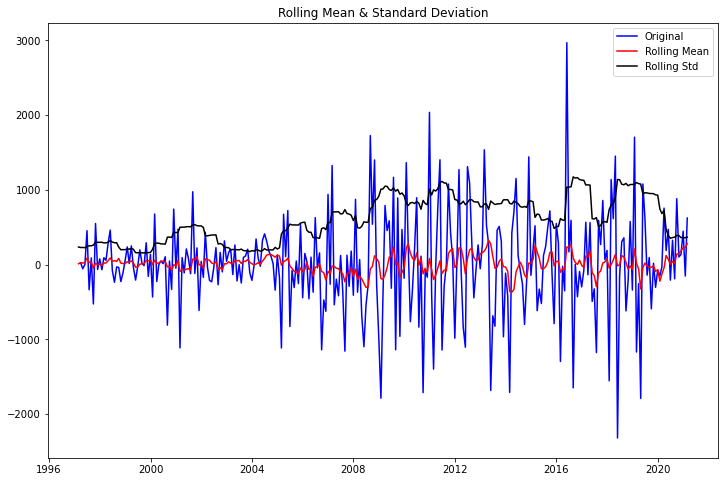

Results of Dickey-Fuller Test:
Test Statistic                  -5.477991
p-value                          0.000002
#Lags Used                      14.000000
Number of Observations Used    285.000000
Critical Value (1%)             -3.453505
Critical Value (5%)             -2.871735
Critical Value (10%)            -2.572202
dtype: float64


In [32]:
test_stationarity(z23226['Zillow Home Value Index (ZHVI)'].diff().diff().dropna(), 12)

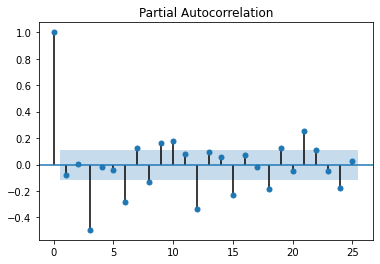

In [33]:
plot_pacf(z23226['Zillow Home Value Index (ZHVI)'].diff().diff().dropna());

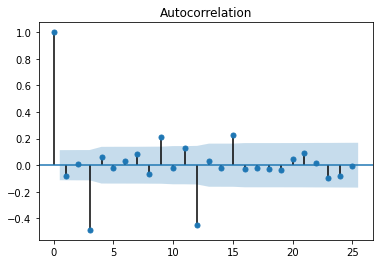

In [34]:
plot_acf(z23226['Zillow Home Value Index (ZHVI)'].diff().diff().dropna());

In [35]:
find_sarimax_parameters(z23226)

,Paramters,AIC
34,"order=(0, 2, 0)seasonal(1, 0, 0, 12)",4262.401262
176,"order=(3, 2, 0)seasonal(0, 0, 0, 12)",4262.674575
33,"order=(0, 2, 0)seasonal(0, 0, 1, 12)",4263.172243
32,"order=(0, 2, 0)seasonal(0, 0, 0, 12)",4263.303420
181,"order=(3, 2, 1)seasonal(0, 0, 1, 12)",4263.496597
81,"order=(1, 2, 0)seasonal(0, 0, 1, 12)",4264.444314
92,"order=(1, 2, 3)seasonal(0, 0, 0, 12)",4264.488164
82,"order=(1, 2, 0)seasonal(1, 0, 0, 12)",4264.507085
37,"order=(0, 2, 1)seasonal(0, 0, 1, 12)",4264.532447
180,"order=(3, 2, 1)seasonal(0, 0, 0, 12)",4264.577832


                                      SARIMAX Results                                       
Dep. Variable:       Zillow Home Value Index (ZHVI)   No. Observations:                  272
Model:             SARIMAX(0, 2, 3)x(0, 0, [1], 12)   Log Likelihood               -2126.558
Date:                              Thu, 22 Apr 2021   AIC                           4265.115
Time:                                      19:10:14   BIC                           4286.706
Sample:                                  01-31-1996   HQIC                          4273.785
                                       - 08-31-2018                                         
Covariance Type:                                opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
financial_crisis_flag  -658.0000    293.199     -2.244      0.025   -1232.66

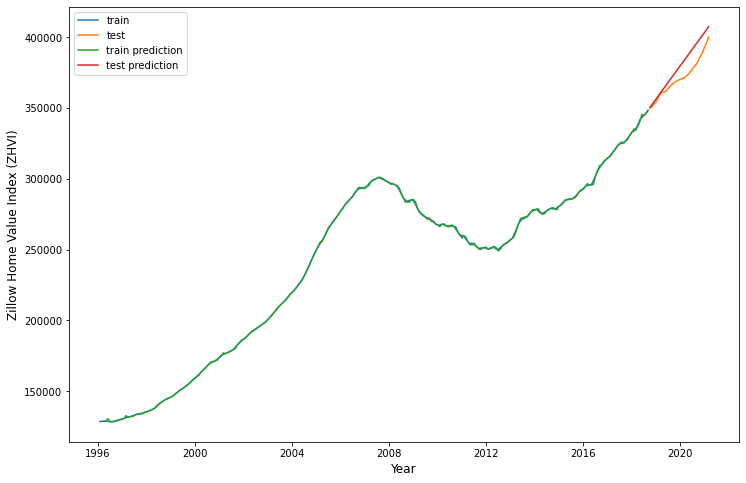

In [36]:
model(z23226, (0, 2, 3), (0, 0, 1, 12))

Test RMSE: 623.1288672673022


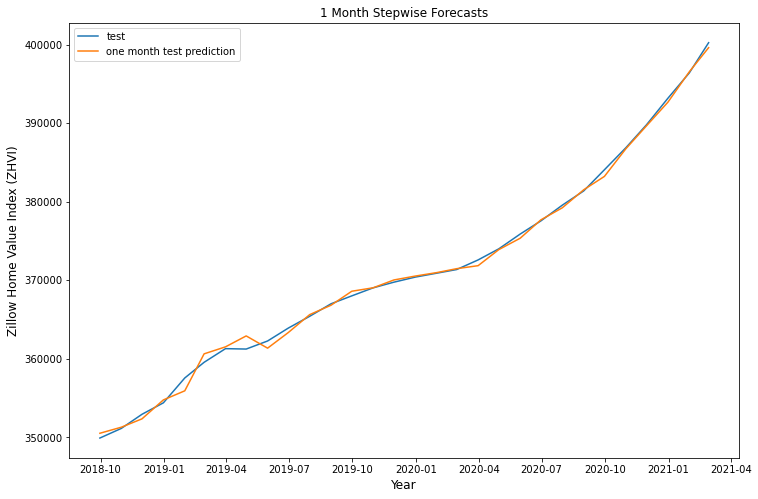

In [37]:
one_period_stepwise_test_results(z23226, (0, 2, 3), (0, 0, 1, 12))

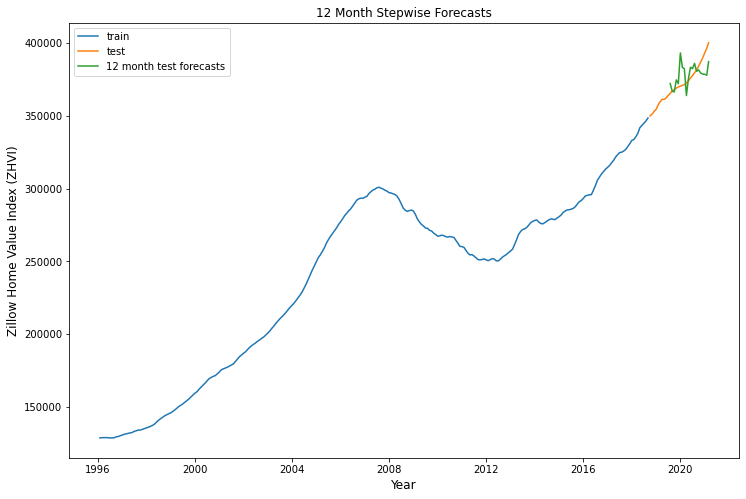

Test RMSE: 9972.653775353912


In [38]:
year_stepwise_test_results(z23226, (0, 2, 3), (0, 0, 1, 12))

---
### Zipcode 23227

Zipcode 23227 saw similar results in paramter tuning as prior zipcodes. Best paramters for this zipcode were order = (0,2,3) and seasonal order = (0,0,1,12).

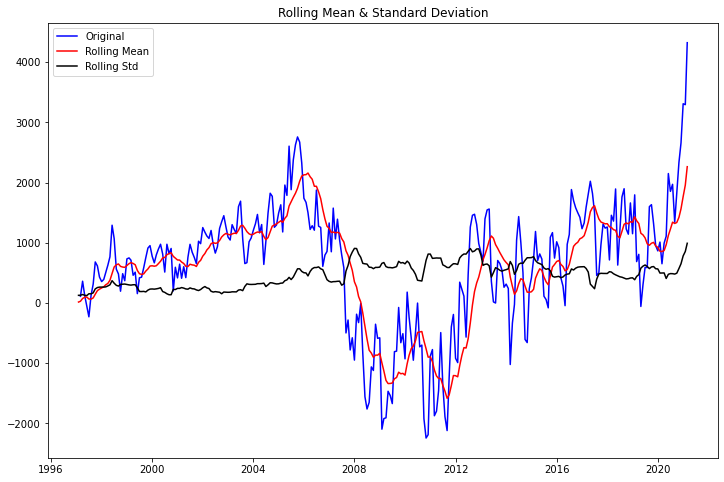

Results of Dickey-Fuller Test:
Test Statistic                  -1.318029
p-value                          0.620884
#Lags Used                      16.000000
Number of Observations Used    284.000000
Critical Value (1%)             -3.453587
Critical Value (5%)             -2.871771
Critical Value (10%)            -2.572222
dtype: float64


In [39]:
test_stationarity(z23227['Zillow Home Value Index (ZHVI)'].diff().dropna(), 12)

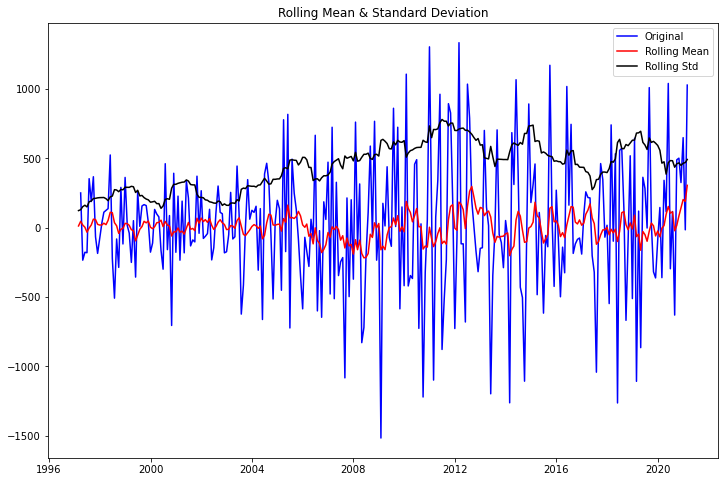

Results of Dickey-Fuller Test:
Test Statistic                  -4.149703
p-value                          0.000801
#Lags Used                      15.000000
Number of Observations Used    284.000000
Critical Value (1%)             -3.453587
Critical Value (5%)             -2.871771
Critical Value (10%)            -2.572222
dtype: float64


In [40]:
test_stationarity(z23227['Zillow Home Value Index (ZHVI)'].diff().diff().dropna(), 12)

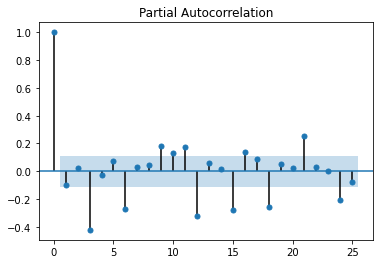

In [41]:
plot_pacf(z23227['Zillow Home Value Index (ZHVI)'].diff().diff().dropna());

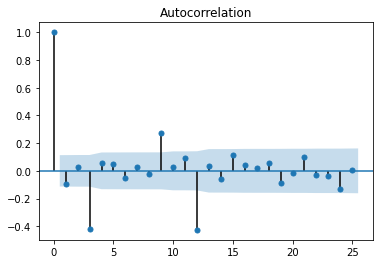

In [42]:
plot_acf(z23227['Zillow Home Value Index (ZHVI)'].diff().diff().dropna());

In [43]:
find_sarimax_parameters(z23227)

,Paramters,AIC
45,"order=(0, 2, 3)seasonal(0, 0, 1, 12)",4048.257096
177,"order=(3, 2, 0)seasonal(0, 0, 1, 12)",4048.304677
46,"order=(0, 2, 3)seasonal(1, 0, 0, 12)",4048.999300
179,"order=(3, 2, 0)seasonal(1, 0, 1, 12)",4049.085271
47,"order=(0, 2, 3)seasonal(1, 0, 1, 12)",4049.137764
178,"order=(3, 2, 0)seasonal(1, 0, 0, 12)",4049.154785
181,"order=(3, 2, 1)seasonal(0, 0, 1, 12)",4049.916744
93,"order=(1, 2, 3)seasonal(0, 0, 1, 12)",4050.007036
183,"order=(3, 2, 1)seasonal(1, 0, 1, 12)",4050.703252
182,"order=(3, 2, 1)seasonal(1, 0, 0, 12)",4050.741959


                                      SARIMAX Results                                       
Dep. Variable:       Zillow Home Value Index (ZHVI)   No. Observations:                  272
Model:             SARIMAX(0, 2, 3)x(0, 0, [1], 12)   Log Likelihood               -2018.129
Date:                              Thu, 22 Apr 2021   AIC                           4048.257
Time:                                      19:11:51   BIC                           4069.848
Sample:                                  01-31-1996   HQIC                          4056.927
                                       - 08-31-2018                                         
Covariance Type:                                opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
financial_crisis_flag  -687.2499    157.343     -4.368      0.000    -995.63

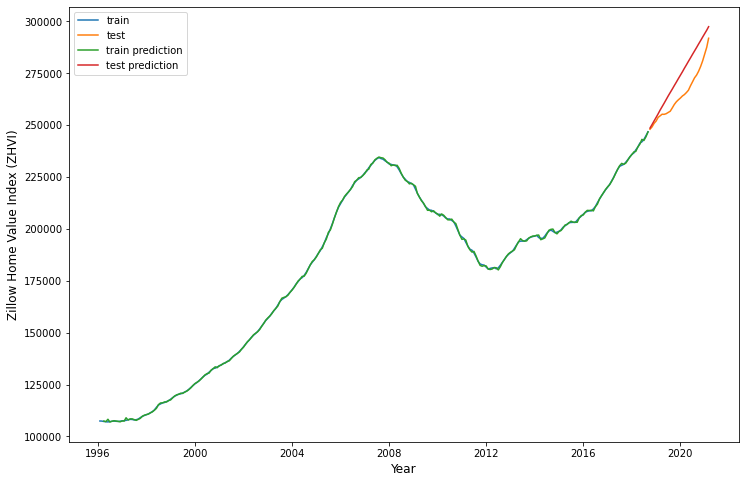

In [44]:
model(z23227, (0, 2, 3), (0, 0, 1, 12))

Test RMSE: 514.9924680366923


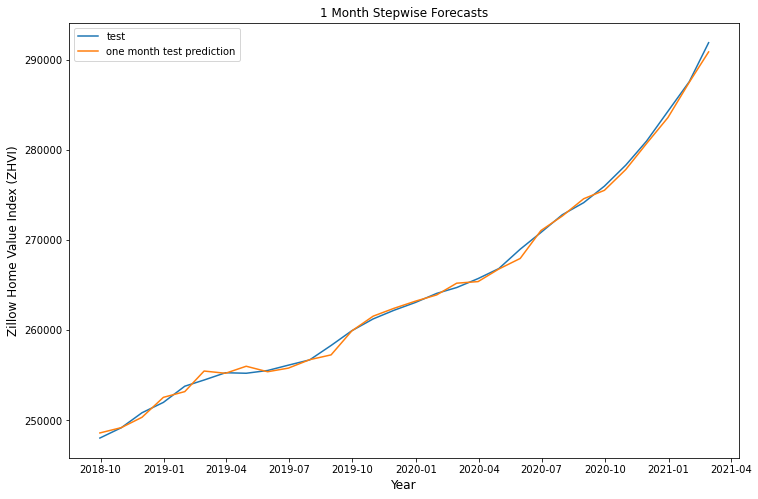

In [45]:
one_period_stepwise_test_results(z23227, (0, 2, 3), (0, 0, 1, 12))

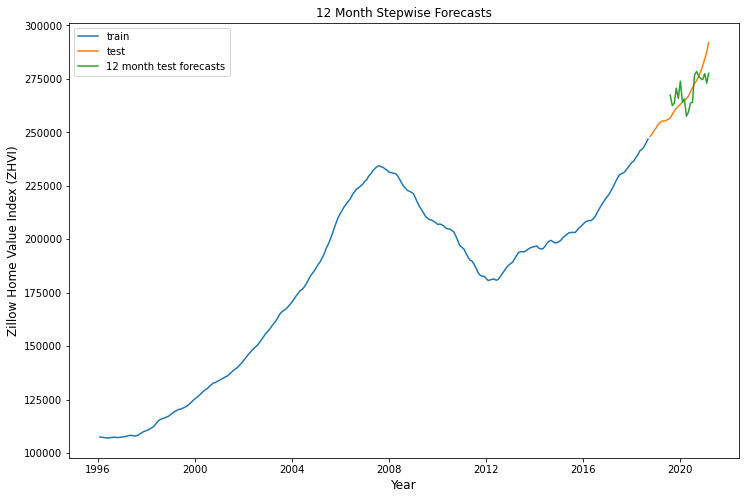

Test RMSE: 7455.114020100175


In [46]:
year_stepwise_test_results(z23227, (0, 2, 3), (0, 0, 1, 12))

---
### Zipcode 23221

Zipcode 23227 saw similar results in paramter tuning as prior zipcodes. Best paramters for this zipcode were order = (0,2,3) and seasonal order = (1,0,0,12).

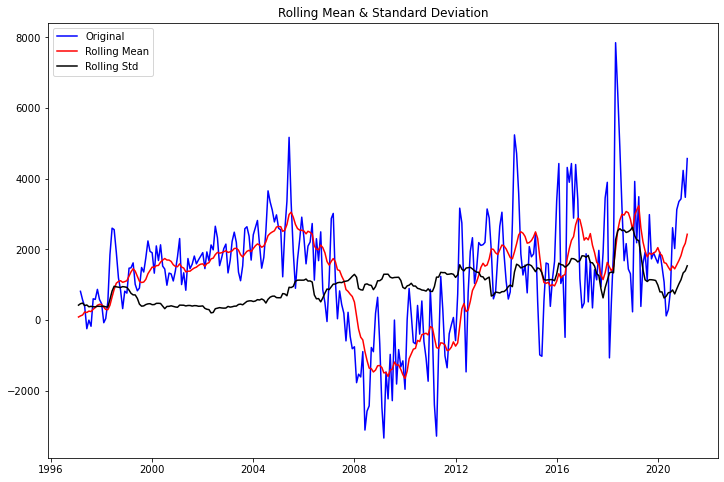

Results of Dickey-Fuller Test:
Test Statistic                  -1.777825
p-value                          0.391525
#Lags Used                      15.000000
Number of Observations Used    285.000000
Critical Value (1%)             -3.453505
Critical Value (5%)             -2.871735
Critical Value (10%)            -2.572202
dtype: float64


In [47]:
test_stationarity(z23221['Zillow Home Value Index (ZHVI)'].diff().dropna(),12)

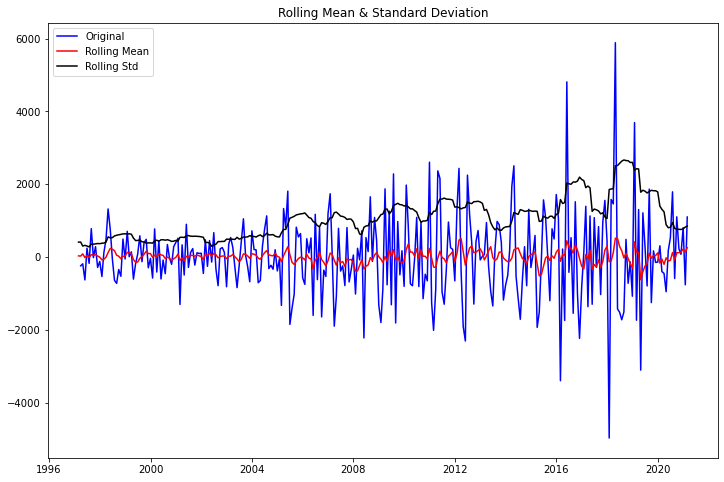

Results of Dickey-Fuller Test:
Test Statistic                -5.845893e+00
p-value                        3.684474e-07
#Lags Used                     1.400000e+01
Number of Observations Used    2.850000e+02
Critical Value (1%)           -3.453505e+00
Critical Value (5%)           -2.871735e+00
Critical Value (10%)          -2.572202e+00
dtype: float64


In [48]:
test_stationarity(z23221['Zillow Home Value Index (ZHVI)'].diff().diff().dropna(),12)

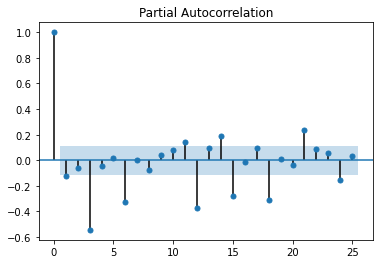

In [49]:
plot_pacf(z23221['Zillow Home Value Index (ZHVI)'].diff().diff().dropna());

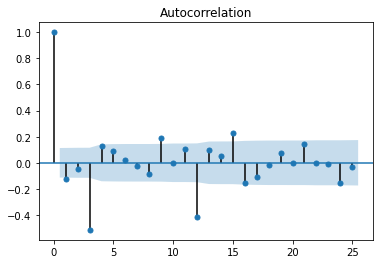

In [50]:
plot_acf(z23221['Zillow Home Value Index (ZHVI)'].diff().diff().dropna());

In [51]:
find_sarimax_parameters(z23221)

,Paramters,AIC
44,"order=(0, 2, 3)seasonal(0, 0, 0, 12)",4549.952699
175,"order=(3, 2, 0)seasonal(0, 0, 0, 12)",4550.098106
47,"order=(0, 2, 3)seasonal(1, 0, 1, 12)",4551.380087
92,"order=(1, 2, 3)seasonal(0, 0, 0, 12)",4551.646523
94,"order=(1, 2, 3)seasonal(1, 0, 0, 12)",4552.008579
180,"order=(3, 2, 1)seasonal(0, 0, 1, 12)",4552.034823
181,"order=(3, 2, 1)seasonal(1, 0, 0, 12)",4552.087516
93,"order=(1, 2, 3)seasonal(0, 0, 1, 12)",4552.356444
140,"order=(2, 2, 3)seasonal(0, 0, 0, 12)",4553.408771
183,"order=(3, 2, 2)seasonal(0, 0, 0, 12)",4555.096405


                                      SARIMAX Results                                       
Dep. Variable:       Zillow Home Value Index (ZHVI)   No. Observations:                  272
Model:             SARIMAX(0, 2, 3)x(0, 0, [1], 12)   Log Likelihood               -2274.333
Date:                              Thu, 22 Apr 2021   AIC                           4560.666
Time:                                      19:13:33   BIC                           4582.257
Sample:                                  01-31-1996   HQIC                          4569.336
                                       - 08-31-2018                                         
Covariance Type:                                opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
financial_crisis_flag -1112.0000    541.793     -2.052      0.040   -2173.89

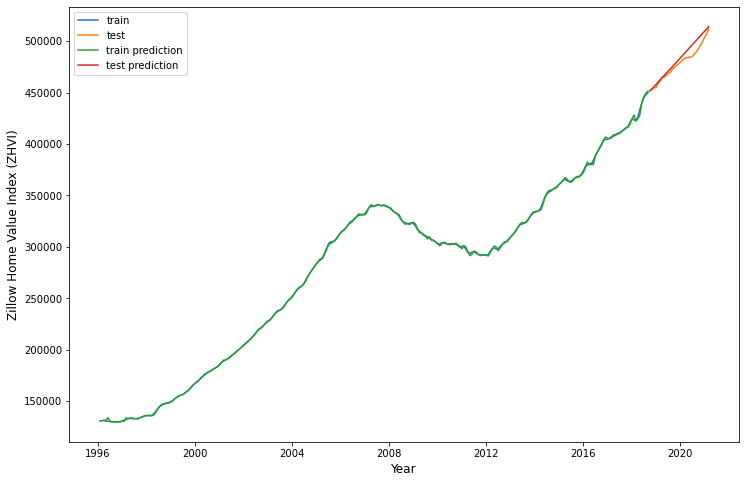

In [52]:
model(z23221, (0, 2, 3), (0, 0, 1, 12))

Test RMSE: 1177.739303021192


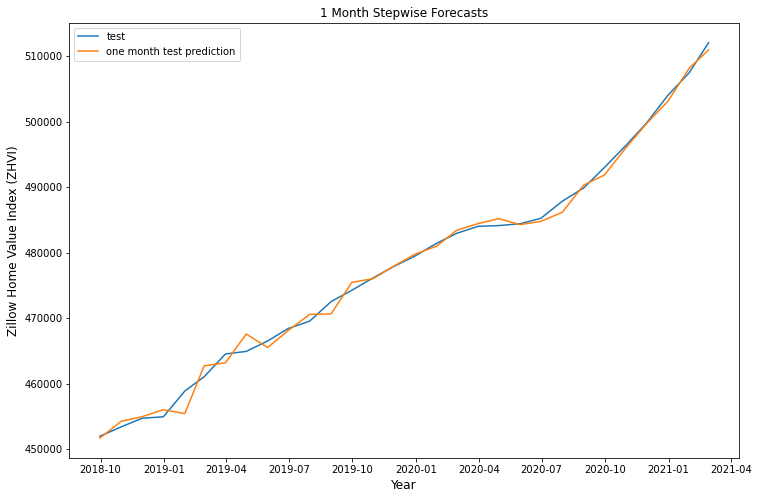

In [53]:
one_period_stepwise_test_results(z23221, (0, 2, 3), (0, 0, 1, 12))

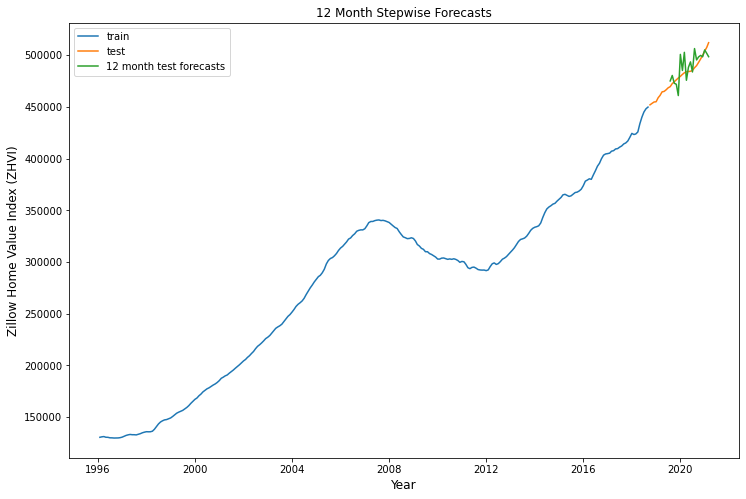

Test RMSE: 10148.237901852837


In [54]:
year_stepwise_test_results(z23221, (0, 2, 3), (0, 0, 1, 12))

---
## SARIMA Forecasting and Evaluating Returns

Now that I have models for each zipcode tuned, I will train them on the entire dataset and forecast one year into the future. Then I will calculate the % price appreciation for the one year forecast. I am assuming there will not be a financial crisis in the next year.

In [55]:
returns_dict = {}

In [56]:
z23060_model = SARIMAX( endog = z23060['Zillow Home Value Index (ZHVI)'], exog = z23060['financial_crisis_flag'] , order = (0, 2, 3), seasonal_order = (0, 0, 1, 12), freq = 'M').fit()
z23060_model_forecast = z23060_model.forecast(steps=12, exog = np.zeros(12))
z23060_return =  (z23060_model_forecast[-1] - z23060['Zillow Home Value Index (ZHVI)'][-1])  / z23060['Zillow Home Value Index (ZHVI)'][-1] 
returns_dict['z23060'] = z23060_return*100

In [57]:
z23220_model = SARIMAX( endog = z23220['Zillow Home Value Index (ZHVI)'], exog = z23220['financial_crisis_flag'] , order = (0, 2, 3), seasonal_order = (0, 0, 1, 12), freq = 'M').fit()
z23220_model_forecast = z23220_model.forecast(steps=12, exog = np.zeros(12))
z23220_return =  (z23220_model_forecast[-1] - z23220['Zillow Home Value Index (ZHVI)'][-1])  / z23220['Zillow Home Value Index (ZHVI)'][-1] 
returns_dict['z23220'] = z23220_return*100

In [58]:
z23221_model = SARIMAX( endog = z23221['Zillow Home Value Index (ZHVI)'], exog = z23221['financial_crisis_flag'] , order = (0, 2, 3), seasonal_order = (0, 0, 1, 12), freq = 'M').fit()
z23221_model_forecast = z23221_model.forecast(steps=12, exog = np.zeros(12))
z23221_return =  (z23221_model_forecast[-1] - z23221['Zillow Home Value Index (ZHVI)'][-1])  / z23221['Zillow Home Value Index (ZHVI)'][-1] 
returns_dict['z23221'] = z23221_return*100

In [59]:
z23226_model = SARIMAX( endog = z23226['Zillow Home Value Index (ZHVI)'], exog = z23226['financial_crisis_flag'] , order = (0, 2, 3), seasonal_order = (0, 0, 1, 12), freq = 'M').fit()
z23226_model_forecast = z23226_model.forecast(steps=12, exog = np.zeros(12))
z23226_return =  (z23226_model_forecast[-1] - z23226['Zillow Home Value Index (ZHVI)'][-1])  / z23226['Zillow Home Value Index (ZHVI)'][-1] 
returns_dict['z23226'] = z23226_return*100

In [60]:
z23227_model = SARIMAX( endog = z23227['Zillow Home Value Index (ZHVI)'], exog = z23227['financial_crisis_flag'] , order = (0, 2, 3), seasonal_order = (0, 0, 1, 12), freq = 'M').fit()
z23227_model_forecast = z23227_model.forecast(steps=12, exog = np.zeros(12))
z23227_return =  (z23227_model_forecast[-1] - z23227['Zillow Home Value Index (ZHVI)'][-1])  / z23227['Zillow Home Value Index (ZHVI)'][-1] 
returns_dict['z23227'] = z23227_return*100

In [61]:
returns_df = pd.DataFrame(returns_dict.items(), columns = ['Zipcode', 'Forecast_1_Year_%_Appreciation'])

Looking purely at the SARIMA model results, zipcode 23227 has the highest forecast return at 16.4% follow by 23060 at 15%.

In [62]:
returns_df = returns_df.sort_values('Forecast_1_Year_%_Appreciation', ascending = False)
returns_df

,Zipcode,Forecast_1_Year_%_Appreciation
4,z23227,16.414476
0,z23060,15.040855
3,z23226,11.010286
2,z23221,10.298132
1,z23220,9.423679


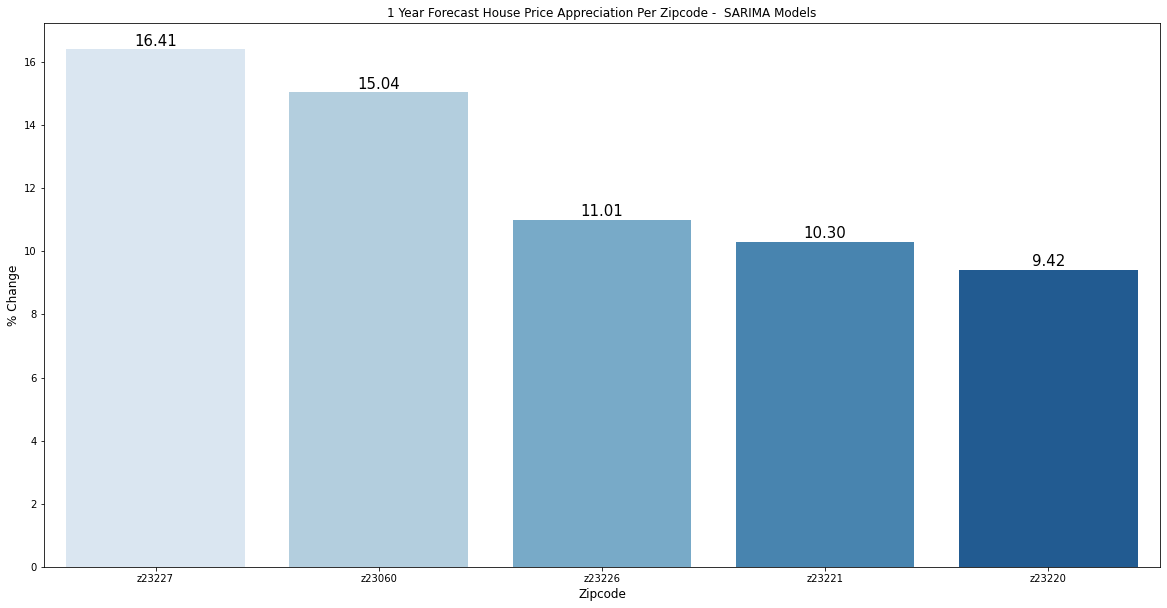

In [63]:
fig, ax = plt.subplots(figsize = (20,10))

ax = sns.barplot(x = returns_df['Zipcode'], y = returns_df['Forecast_1_Year_%_Appreciation'], orient = 'v', palette = 'Blues')
ax.set_title('1 Year Forecast House Price Appreciation Per Zipcode -  SARIMA Models', fontsize = 12)
ax.set_ylabel('% Change', fontsize =12)
ax.set_xlabel('Zipcode', fontsize =12)
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
plt.show()

Looking at the forecasts below, it seems the model may be more influenced by the more recent pricing trends where house prices in the past few months have increased more dramatically then historically due to COVID and very low interest rates. Additionally, the two leading zipcodes are both more suburban than the others, possibly telling of the COVID affect where people desire bigger houses and lots and can be further from business centers they no longer need to commute to.

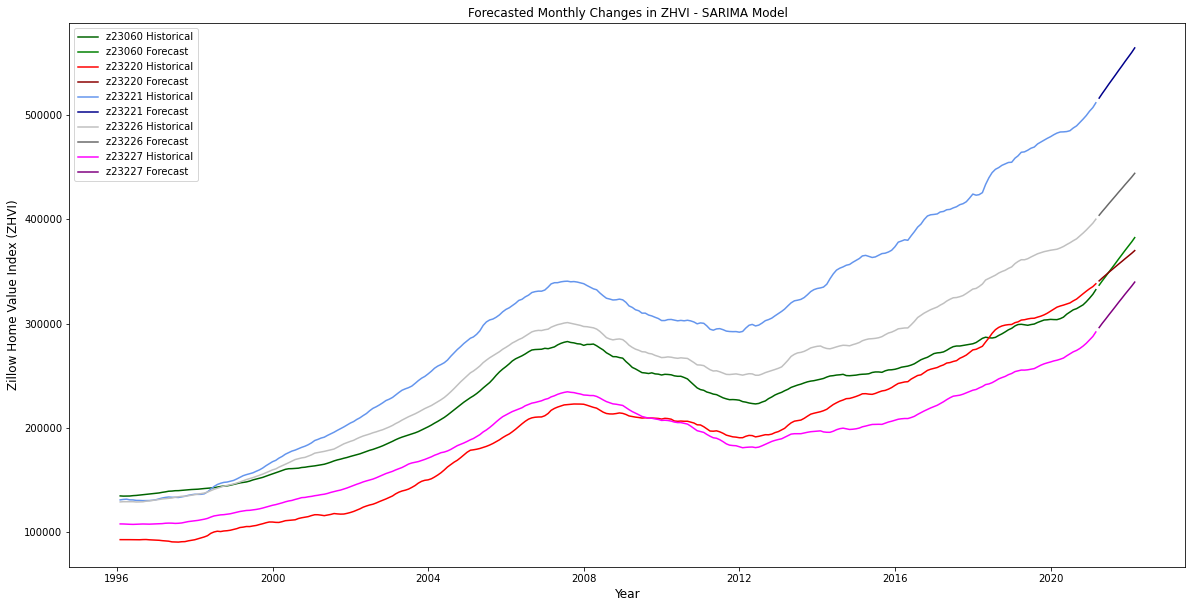

In [64]:
fig, ax = plt.subplots(figsize = (20,10))

ax.plot(z23060['Zillow Home Value Index (ZHVI)'], label='z23060 Historical', color = 'darkgreen')
ax.plot(z23060_model_forecast, label='z23060 Forecast', color = 'green')

ax.plot(z23220['Zillow Home Value Index (ZHVI)'], label='z23220 Historical', color = 'red')
ax.plot(z23220_model_forecast, label='z23220 Forecast', color = 'darkred')

ax.plot(z23221['Zillow Home Value Index (ZHVI)'], label='z23221 Historical', color = 'cornflowerblue')
ax.plot(z23221_model_forecast, label='z23221 Forecast', color = 'darkblue')

ax.plot(z23226['Zillow Home Value Index (ZHVI)'], label='z23226 Historical', color = 'silver')
ax.plot(z23226_model_forecast, label='z23226 Forecast', color = 'dimgrey')

ax.plot(z23227['Zillow Home Value Index (ZHVI)'], label='z23227 Historical', color = 'fuchsia')
ax.plot(z23227_model_forecast, label='z23227 Forecast', color = 'purple')

ax.set_ylabel('Zillow Home Value Index (ZHVI)', fontsize = 12)
ax.set_xlabel('Year', fontsize = 12)
plt.legend()

ax.set_title(f"Forecasted Monthly Changes in ZHVI - SARIMA Model");

plt.show()

## Facebook Prophet Modeling

Facebook 'Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.'

I will use Facebook Prophet to model and forecast the data. I will see if there are different results using this implementation compared to the SARIMA models. 

Ultimately, I will combine the result from the SARIMA models and the Prophet models to make an ultimate recommendation. 

In [65]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

Importing plotly failed. Interactive plots will not work.


In [66]:
def df_to_prophet(df):
    new = df.reset_index()
    new.rename(columns = {'index' : 'ds', 'Zillow Home Value Index (ZHVI)': 'y'}, inplace = True)
    return new

In [67]:
def prophet_model(df):
    new_df = df_to_prophet(df)
    model = Prophet(changepoint_range= 1, changepoint_prior_scale=0.08)
    model.fit(new_df)
    future = model.make_future_dataframe(periods = 12, freq = 'M')
    forecast = model.predict(future)
    return model, forecast

In [68]:
z23220_prophet_model, z23220_prophet_forecast = prophet_model(z23220)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [69]:
z23221_prophet_model, z23221_prophet_forecast = prophet_model(z23221)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [70]:
z23060_prophet_model, z23060_prophet_forecast = prophet_model(z23060)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [71]:
z23226_prophet_model, z23226_prophet_forecast = prophet_model(z23226)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [72]:
z23227_prophet_model, z23227_prophet_forecast = prophet_model(z23227)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


I can see from the below charts and results that the forecasts from the Facebook Prophet models are more conservative than from the SARIMA models.

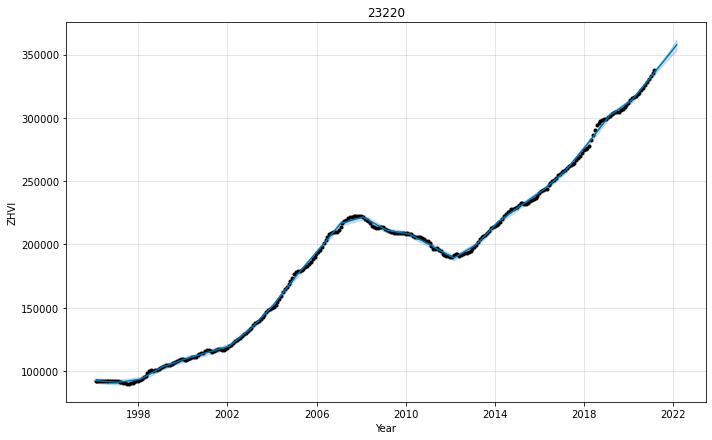

In [73]:
fig = z23220_prophet_model.plot(z23220_prophet_forecast, xlabel = 'Year', ylabel = 'ZHVI', uncertainty = True )
ax = fig.gca()
ax.set_title("23220")
plt.show()

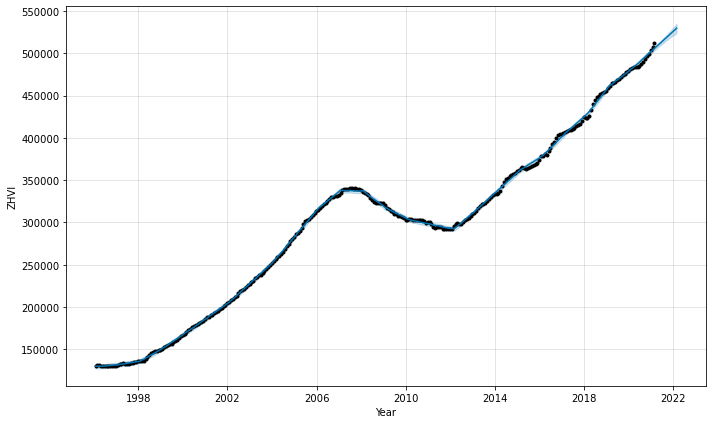

In [74]:
fig2 = z23221_prophet_model.plot(z23221_prophet_forecast, xlabel = 'Year', ylabel = 'ZHVI', uncertainty = True )
ax2 = fig.gca()
ax2.set_title("23221")
plt.show()

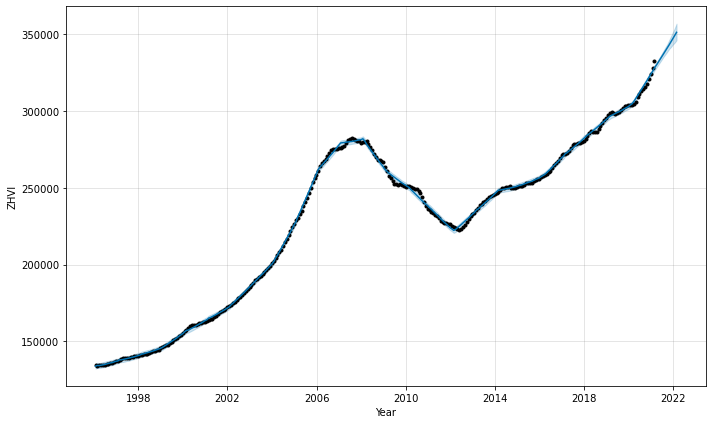

In [75]:
fig3 = z23060_prophet_model.plot(z23060_prophet_forecast, xlabel = 'Year', ylabel = 'ZHVI', uncertainty = True )
ax3 = fig.gca()
a = add_changepoints_to_plot(fig.gca(), z23060_prophet_model, z23060_prophet_forecast)
plt.show()

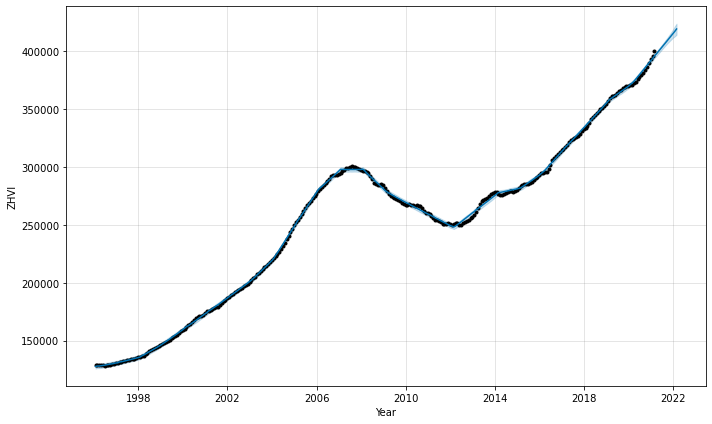

In [76]:
fig4 = z23226_prophet_model.plot(z23226_prophet_forecast, xlabel = 'Year', ylabel = 'ZHVI', uncertainty = True )
ax4 = fig.gca()
a = add_changepoints_to_plot(fig.gca(), z23226_prophet_model, z23226_prophet_forecast)


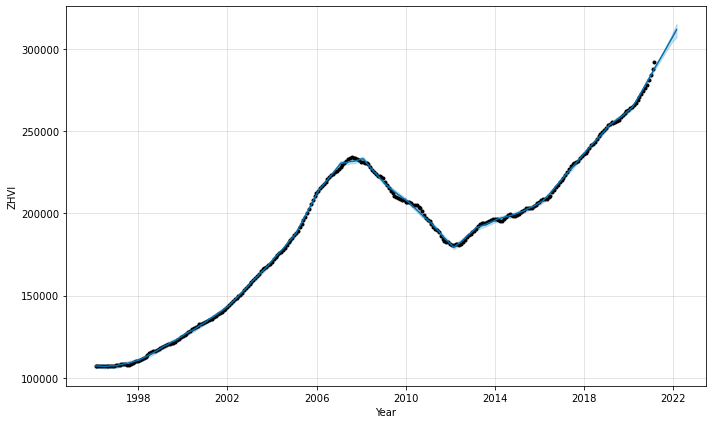

In [77]:
fig5 = z23227_prophet_model.plot(z23227_prophet_forecast, xlabel = 'Year', ylabel = 'ZHVI', uncertainty = True )
ax5 = fig.gca()
a = add_changepoints_to_plot(fig.gca(), z23227_prophet_model, z23227_prophet_forecast)

In [78]:
z23060_prophet_forecast_returns = (z23060_prophet_forecast.loc[313,'yhat'] - z23060['Zillow Home Value Index (ZHVI)'][-1]) / z23060['Zillow Home Value Index (ZHVI)'][-1]
z23220_prophet_forecast_returns = (z23220_prophet_forecast.loc[313,'yhat'] - z23220['Zillow Home Value Index (ZHVI)'][-1]) / z23220['Zillow Home Value Index (ZHVI)'][-1]
z23221_prophet_forecast_returns = (z23221_prophet_forecast.loc[313,'yhat'] - z23221['Zillow Home Value Index (ZHVI)'][-1]) / z23221['Zillow Home Value Index (ZHVI)'][-1]
z23226_prophet_forecast_returns = (z23226_prophet_forecast.loc[313,'yhat'] - z23226['Zillow Home Value Index (ZHVI)'][-1]) / z23226['Zillow Home Value Index (ZHVI)'][-1]
z23227_prophet_forecast_returns = (z23227_prophet_forecast.loc[313,'yhat'] - z23227['Zillow Home Value Index (ZHVI)'][-1]) / z23226['Zillow Home Value Index (ZHVI)'][-1] 
prophet_returns_dict = {'z23060' : z23060_prophet_forecast_returns*100, 'z23220' : z23220_prophet_forecast_returns*100, 'z23221': z23221_prophet_forecast_returns*100, 'z23226': z23226_prophet_forecast_returns*100, 'z23227':z23227_prophet_forecast_returns*100 }

In [79]:
prophet_returns_dict

{'z23060': 5.660039508574587,
 'z23220': 5.766928355272208,
 'z23221': 3.480595172898737,
 'z23226': 4.7886617155092654,
 'z23227': 4.9543592929481}

The Facebook Prophet models forecast 23220 with the highest return of 5.77% but 23060 is very close behind with 5.67. 23227 which did best in the SARIMA modeling is 3rd with 4.95.

In [80]:
prophet_returns_df = pd.DataFrame(prophet_returns_dict.items(), columns = ['Zipcode', 'Forecast_1_Year_%_Appreciation'])
prophet_returns_df = prophet_returns_df.sort_values('Forecast_1_Year_%_Appreciation', ascending = False)
prophet_returns_df

,Zipcode,Forecast_1_Year_%_Appreciation
1,z23220,5.766928
0,z23060,5.660040
4,z23227,4.954359
3,z23226,4.788662
2,z23221,3.480595


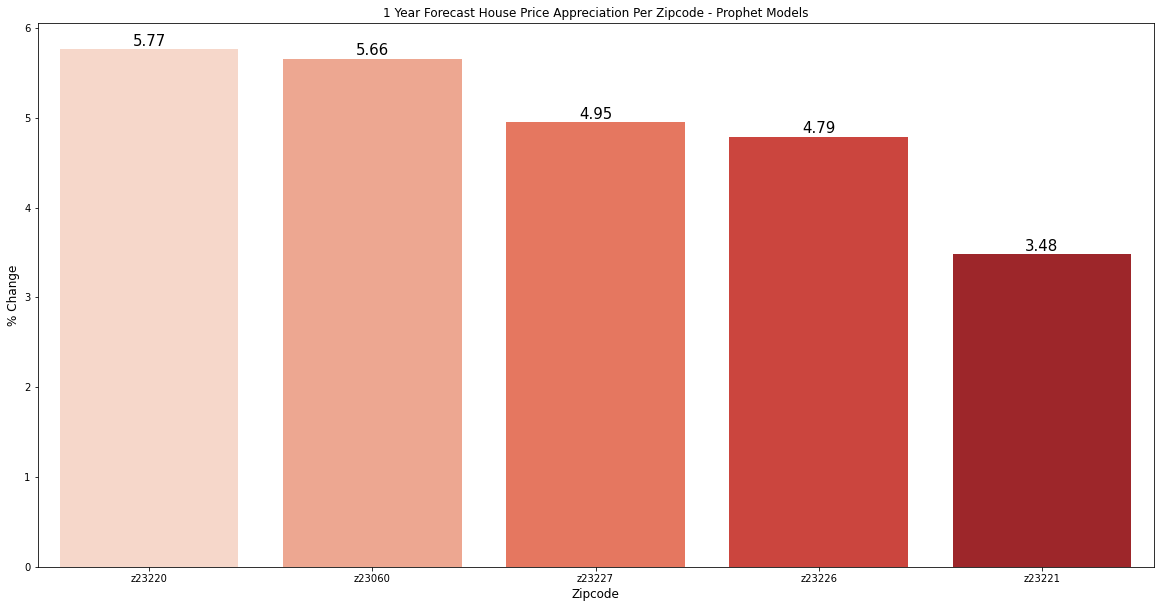

In [81]:
fig, ax = plt.subplots(figsize = (20,10))

ax = sns.barplot(x = prophet_returns_df['Zipcode'], y = prophet_returns_df['Forecast_1_Year_%_Appreciation'], orient = 'v', palette = 'Reds')
ax.set_title('1 Year Forecast House Price Appreciation Per Zipcode - Prophet Models', fontsize = 12)
ax.set_ylabel('% Change', fontsize =12)
ax.set_xlabel('Zipcode', fontsize =12)
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
plt.show()

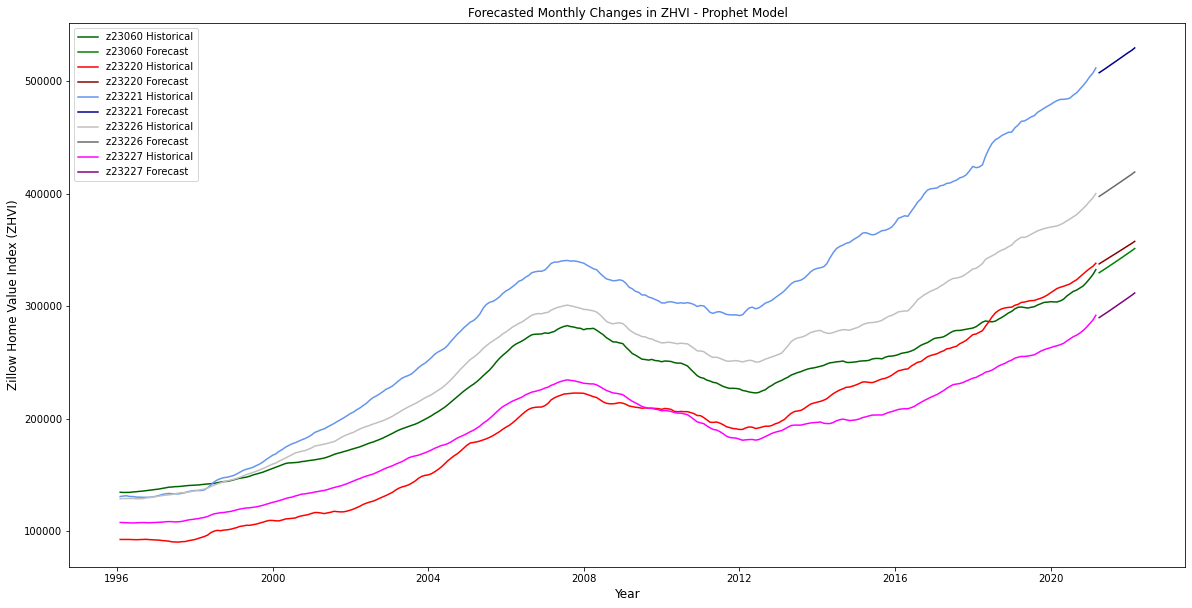

In [82]:
fig, ax = plt.subplots(figsize = (20,10))

ax.plot(z23060['Zillow Home Value Index (ZHVI)'], label='z23060 Historical', color = 'darkgreen')
ax.plot(z23060_prophet_forecast.set_index('ds').loc['2021-03-30':, 'yhat'], label='z23060 Forecast', color = 'green')

ax.plot(z23220['Zillow Home Value Index (ZHVI)'], label='z23220 Historical', color = 'red')
ax.plot(z23220_prophet_forecast.set_index('ds').loc['2021-03-30':, 'yhat'], label='z23220 Forecast', color = 'darkred')

ax.plot(z23221['Zillow Home Value Index (ZHVI)'], label='z23221 Historical', color = 'cornflowerblue')
ax.plot(z23221_prophet_forecast.set_index('ds').loc['2021-03-30':, 'yhat'], label='z23221 Forecast', color = 'darkblue')

ax.plot(z23226['Zillow Home Value Index (ZHVI)'], label='z23226 Historical', color = 'silver')
ax.plot(z23226_prophet_forecast.set_index('ds').loc['2021-03-30':, 'yhat'], label='z23226 Forecast', color = 'dimgrey')

ax.plot(z23227['Zillow Home Value Index (ZHVI)'], label='z23227 Historical', color = 'fuchsia')
ax.plot(z23227_prophet_forecast.set_index('ds').loc['2021-03-30':, 'yhat'], label='z23227 Forecast', color = 'purple')

ax.set_ylabel('Zillow Home Value Index (ZHVI)', fontsize = 12)
ax.set_xlabel('Year', fontsize = 12)
plt.legend()

ax.set_title(f"Forecasted Monthly Changes in ZHVI - Prophet Model");

plt.show()

In general the Prophet model predicted much lower price appreciation than the SARIMA model. It seems the SARIMA model took the most recent trend and expanded on it while the Prophet model smoothed the trend more over the entire time dataset. The large difference further justify taking the average of the two. The below chart shows the difference in the SARIMA model vs the Prophet model for 23060 and 23227

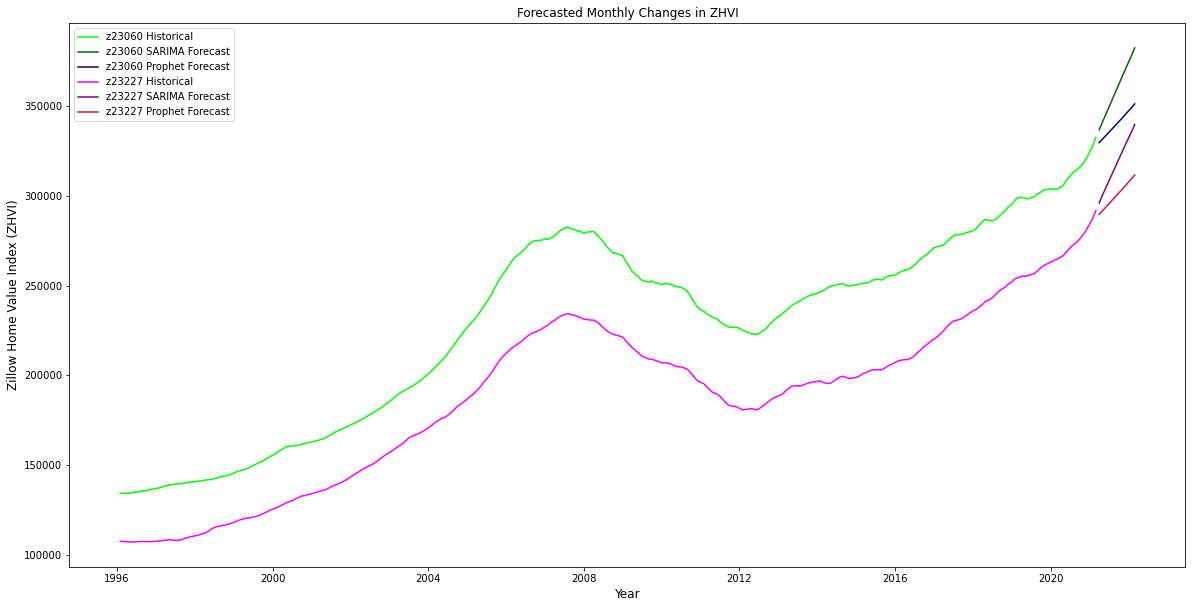

In [83]:
fig, ax = plt.subplots(figsize = (20,10))

ax.plot(z23060['Zillow Home Value Index (ZHVI)'], label='z23060 Historical', color = 'lime')
ax.plot(z23060_model_forecast, label='z23060 SARIMA Forecast', color = 'darkgreen')
ax.plot(z23060_prophet_forecast.set_index('ds').loc['2021-03-30':, 'yhat'], label='z23060 Prophet Forecast', color = 'navy')


ax.plot(z23227['Zillow Home Value Index (ZHVI)'], label='z23227 Historical', color = 'fuchsia')
ax.plot(z23227_model_forecast, label='z23227 SARIMA Forecast', color = 'purple')
ax.plot(z23227_prophet_forecast.set_index('ds').loc['2021-03-30':, 'yhat'], label='z23227 Prophet Forecast', color = 'crimson')

ax.set_ylabel('Zillow Home Value Index (ZHVI)', fontsize = 12)
ax.set_xlabel('Year', fontsize = 12)
plt.legend()

ax.set_title(f"Forecasted Monthly Changes in ZHVI");

plt.show()

---
## Final Results

I'll merge the results from both models into one dataframe and find the average. 

In [84]:
all_returns_df = returns_df.merge(prophet_returns_df, on = 'Zipcode', suffixes = ('_SARIMAX', '_Prophet'))

all_returns_df['Average'] = (all_returns_df['Forecast_1_Year_%_Appreciation_SARIMAX'] + all_returns_df['Forecast_1_Year_%_Appreciation_Prophet']) / 2

all_returns_df = all_returns_df.sort_values('Average', ascending = False)

all_returns_df

,Zipcode,Forecast_1_Year_%_Appreciation_SARIMAX,Forecast_1_Year_%_Appreciation_Prophet,Average
0,z23227,16.414476,4.954359,10.684418
1,z23060,15.040855,5.660040,10.350447
2,z23226,11.010286,4.788662,7.899474
4,z23220,9.423679,5.766928,7.595304
3,z23221,10.298132,3.480595,6.889363


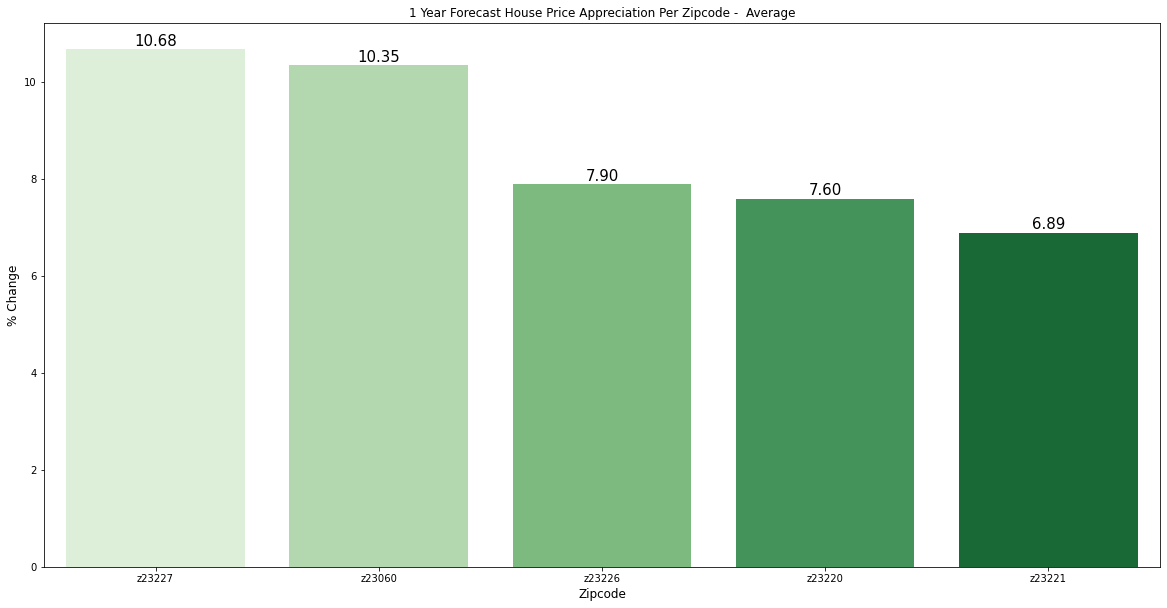

In [85]:
fig, ax = plt.subplots(figsize = (20,10))

ax = sns.barplot(x = all_returns_df['Zipcode'], y = all_returns_df['Average'], orient = 'v', palette = 'Greens')
ax.set_title('1 Year Forecast House Price Appreciation Per Zipcode -  Average', fontsize = 12)
ax.set_ylabel('% Change', fontsize =12)
ax.set_xlabel('Zipcode', fontsize =12)
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
plt.show()

---
## Conclusion

My final recommendation is that the company should invest in houses in zipcode 23227, which contains the neighborhood of Bellevue, a picturesque area just outside the city and the town of Chamberlayne. My models forecast a one year price appreciation of 10.7%. The SARIMAX model was more accurate on the test data for zipcode 23227 relative to zipcode 23060 as well, lending further credence that 23227 is the strongest zipcode. Zipcode 23060 was a clost second place and is another good option relative to the other three zipcodes with a forecasted appreciation of 10.4%.

Annecdotally these two zipcodes are the most suburban zipcodes of the five, recent real estate trends due to COVID and low interest rates show greater price appreciation in houses for suburban areas. 

## Next Steps
Going further with more time and resources, I would like to take the following additional steps in order to improve the project:
- Add more ZIP codes to the analysis
- Do more model tuning with Facebook Prophet
- Do stepwise testing forecasting, testing and model evaluation with Facebook Prophet
- Interview real estate agents about the market trends to get qualitative analysis
